# Visualizing Overfitting and Model Complexity

## Preamble

First we import all the necassary modules.

In [15]:
%load_ext autoreload
%autoreload 2

# Set environment variables because cvxopt might hang otherwise
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

# import courselib utils
from AppliedML.courselib.utils.metrics import accuracy, mean_squared_error
from AppliedML.courselib.utils.preprocessing import labels_encoding
from AppliedML.courselib.utils.splits import train_test_split
from AppliedML.courselib.optimizers import GDOptimizer

# import synthetic data generators
import datagen.ConcentricBands as cc
import datagen.HalfMoons as hm
import datagen.Spirals as sp
import datagen.SeparatedBlobs as sb
import datagen.Postprocessors as pp

# import models
from models.TunableModel import TunableModel
from models.TunableNN import TunableNN
from models.TunableKernelSVM import TunableKernelSVM
from models.TunableRandomForest import TunableRandomForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from dataclasses import dataclass
from typing import Union

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


train_tunable_model is used for training the models, computing the final accuracy for training and test data:

In [16]:
@dataclass
class ExperimentConfig:
    tunable_model: TunableModel
    train_df: pd.DataFrame
    test_df: pd.DataFrame
    training_params: Union[dict, callable]
    encode_label: callable
    measure_accuracy: callable
    random_seed: int
    show_metrics_history: bool = False

def train_tunable_model(cf):
    np.random.seed(cf.random_seed)

    # train models
    models = cf.tunable_model.fit(
        X = cf.train_df[['x', 'y']].to_numpy(),
        y = cf.encode_label(cf.train_df['label']),
        training_params = cf.training_params,
    )

    models = [{"i": i, "model": model, "params": params, "metrics_hist": metrics_hist} 
              for i, model, params, metrics_hist in models]
    models.sort(key=lambda model: model["i"])

    # generate final accuracies
    for model in models:
        model["acc_train"] = cf.measure_accuracy(model["model"], cf.train_df)
        model["acc_test"] = cf.measure_accuracy(model["model"], cf.test_df)
    return models

We use plot_metrics_history to visualize the training process and plot_decision to visualize the result. plot_model combines them, but only executes plot_metrics_history if corresponding data is available.

In [17]:
def plot_metrics_history(models, title_generator):
    fig, axs = plt.subplots(1, len(models), figsize=(8*len(models), 8))
    if len(models) == 1:
        axs = np.array([axs])
        
    for ax, model in zip(axs.flat, models):
        ax.set_title(title_generator(model["params"]))

        metrics_hist = model["metrics_hist"]
        if metrics_hist is None:
            ax.text(0.5, 0.5, "No metrics available", horizontalalignment='center', verticalalignment='center')
            continue
        
        xs = range(len(metrics_hist['accuracy']))
        acc = metrics_hist['accuracy']
        loss = metrics_hist['loss']

        acc_plt = ax.plot(xs, acc, color='orange', label='Accuracy')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        
        ax2 = ax.twinx()
        loss_plt = ax2.plot(xs, loss, color='blue', label='Loss')
        ax2.set_ylabel('Loss')
        
        plots = acc_plt + loss_plt
        labels = [p.get_label() for p in plots]
        ax.legend(plots, labels, loc='best')
    plt.tight_layout()
    plt.show()

def plot_decision(trained_models, train_df, test_df, title_generator):
    fig, axs = plt.subplots(1, len(trained_models), figsize=(8*len(trained_models), 8))
    if len(trained_models) == 1:
        axs = np.array([axs])
        
    df = pd.concat([train_df, test_df])
    
    x_min, x_max = df['x'].min() - 0.5, df['x'].max() + 0.5
    y_min, y_max = df['y'].min() - 0.5, df['y'].max() + 0.5
    
    x_list, y_list = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_list = np.dstack([x_list, y_list])
    
    cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
    colors = df['label'].astype("category").cat.codes
    
    num_train_samples = len(train_df)
    colors_train = colors[:num_train_samples]
    colors_test = colors[num_train_samples:]
    
    for ax, trained_model in zip(axs.flat, trained_models):
        ax.set_title(title_generator(trained_model["params"]))
        ax.set(aspect="equal")  

        model = trained_model["model"]
        h_list = model(X_list)
        
        ax.text(0.5, -0.1, f"Final train accuracy: {trained_model['acc_train']:.1f}%\n"
                           f"Test accuracy: {trained_model['acc_test']:.1f}%", 
                transform=ax.transAxes, ha='center', va='top', fontsize=12)
    
        ax.contourf(x_list, y_list, h_list, cmap=cmap, alpha=0.3)
        
        ax.scatter(test_df['x'], test_df['y'], c=colors_test, edgecolor='k', alpha=0.6, s=5)
        ax.scatter(train_df['x'], train_df['y'], c=colors_train, edgecolor='k')
        
    plt.tight_layout()
    plt.show()

def plot_model(trained_models, train_df, test_df, title_generator):
    has_metrics = len([model["metrics_hist"] for model in trained_models if model["metrics_hist"] is not None]) > 0
    if has_metrics:
        plot_metrics_history(trained_models, title_generator)
    plot_decision(trained_models, train_df, test_df, title_generator)

To visualize our synthetic data we use plot_gen:

In [18]:
def plot_gens(gens, labels, size=6):    
    fig, axs = plt.subplots(1, len(gens), figsize=(size*len(gens), size))

    for ax, gen, label in zip(axs.flat, gens, labels):
        df = gen.sample(num_samples=200)
        colors = df['label'].astype("category").cat.codes
        ax.scatter(df['x'], df['y'], c=colors, edgecolor='k')   
        
        ax.set_title(label)
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)

    plt.tight_layout()
    plt.show()

## Synthetic data

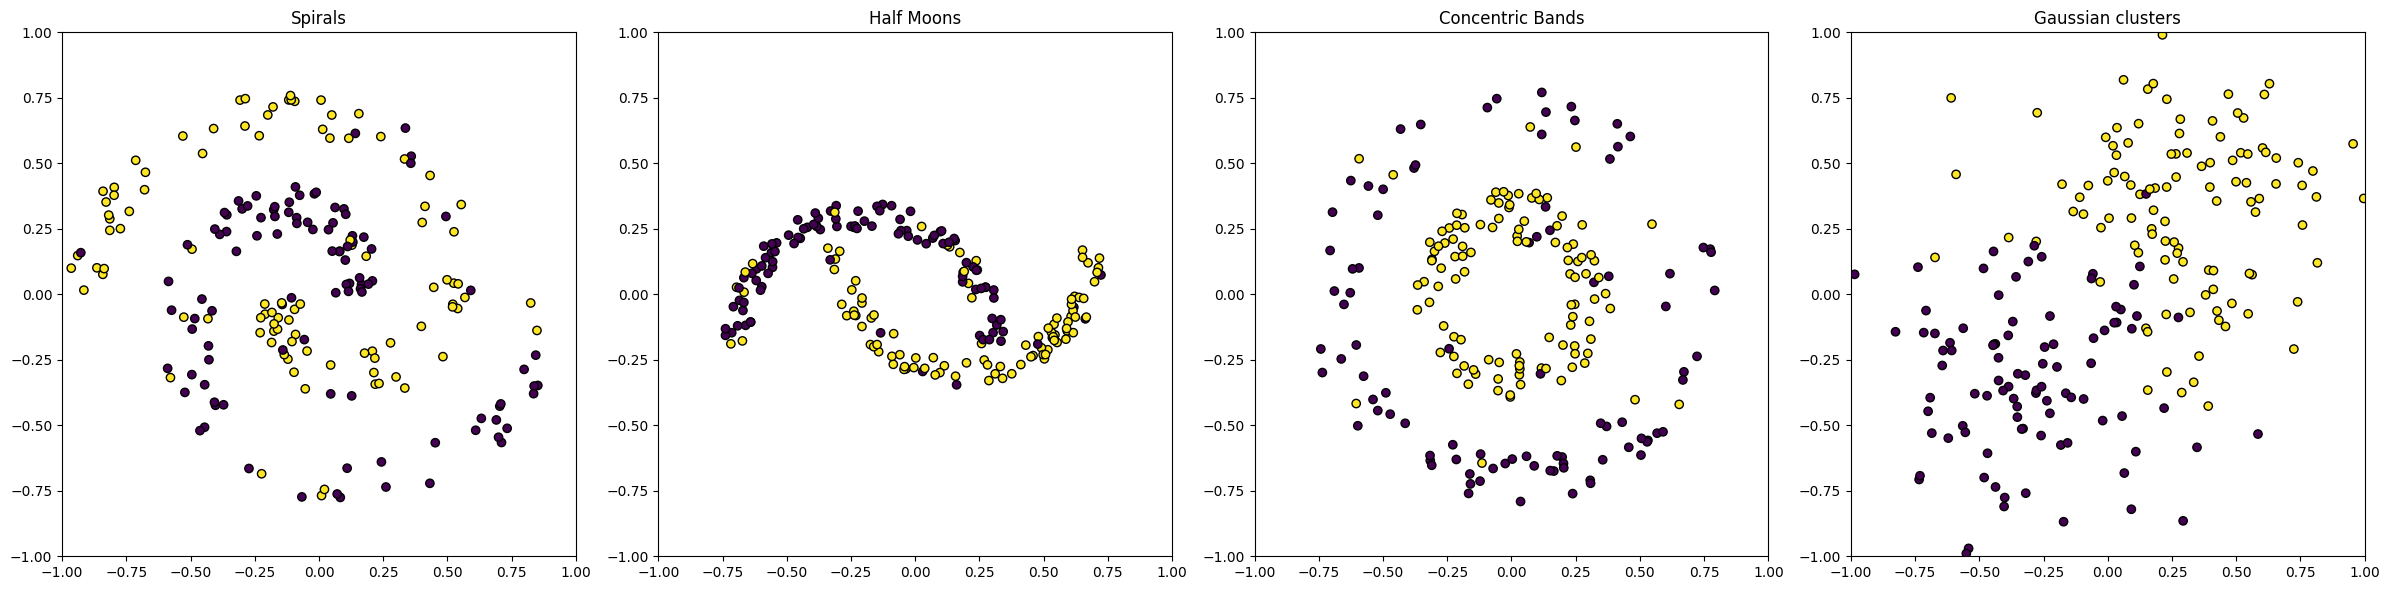

In [19]:
np.random.seed(1)
spirals = sp.Spirals(sp.SpiralConf(2, 0.2, 0.1, 0.9, 1))
spirals.add_postprocessor(pp.LabelSwitch(labels=spirals.labels.values(), noise_freq=0.1))

half_moons = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2), width=0.1, angle_range=(0,np.pi)),
                          hm.HalfMoonConf(centre=(0.2,0.2), width=0.1,angle_range=(np.pi,np.pi*2))])
half_moons.add_postprocessor(pp.LabelSwitch(labels=half_moons.labels.values(), noise_freq=0.1))

conc_bands = cc.ConcentricBands([cc.CBandConf(0.7, 0.2), cc.CBandConf(0.3, 0.2)])
conc_bands.add_postprocessor(pp.LabelSwitch(labels=conc_bands.labels.values(), noise_freq=0.1))

np.random.seed(5)
sep_blobs = sb.SeparatedBlobs([sb.SepBlobConf(-0.3, -0.3, 0.3), sb.SepBlobConf(0.3, 0.3, 0.3)])

plot_gens([spirals  , half_moons  , conc_bands        , sep_blobs], 
          ["Spirals", "Half Moons", "Concentric Bands", "Gaussian clusters"])

## Perceptrons

In [20]:
def trainNN(hyperparameters, test_df, train_df, num_epochs, num_batches, random_seed, show_metrics_history=True):
    tunable_model = TunableNN(hyperparameters=hyperparameters)
    
    training_params = {
        'num_epochs': num_epochs,
        'batch_size': (len(train_df)) // num_batches,
        'compute_metrics': True,
        'metrics_dict': {'accuracy': accuracy, 'loss': mean_squared_error}
    }

    encode_label = lambda ls: labels_encoding(ls.to_numpy())
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model.decision_function(data[['x', 'y']].to_numpy()), 
            encode_label(data['label'])
        )
        
    configNN = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=training_params,
        encode_label=encode_label,
        measure_accuracy=measure_accuracy,
        random_seed=random_seed,
        show_metrics_history=show_metrics_history
    )
    
    return train_tunable_model(configNN)

In [21]:
train_split = 0.2
df, train_df, test_df = train_test_split(
    sep_blobs.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

params = {
    'widths': list(map(lambda x: (2,)+(10,)*x+(2,), [0,1,2,4,8,16]))[::-1],
    'activation': ["ReLU"],
    'optimizer': GDOptimizer(learning_rate=0.5)
}

trained_models = trainNN(params, train_df=train_df, test_df=test_df, num_epochs=7000, num_batches = 1, random_seed=1)

Fitting 6 models with 6 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done



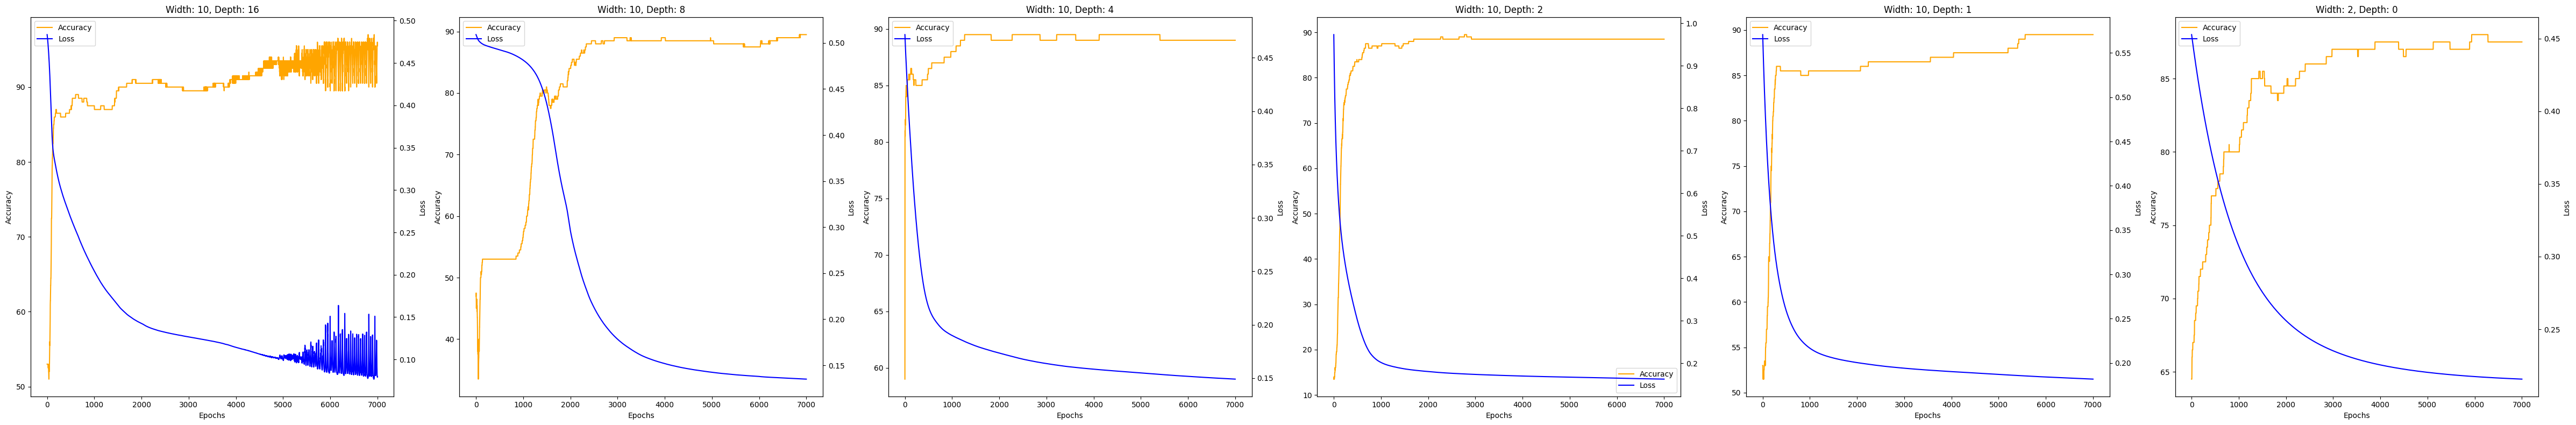

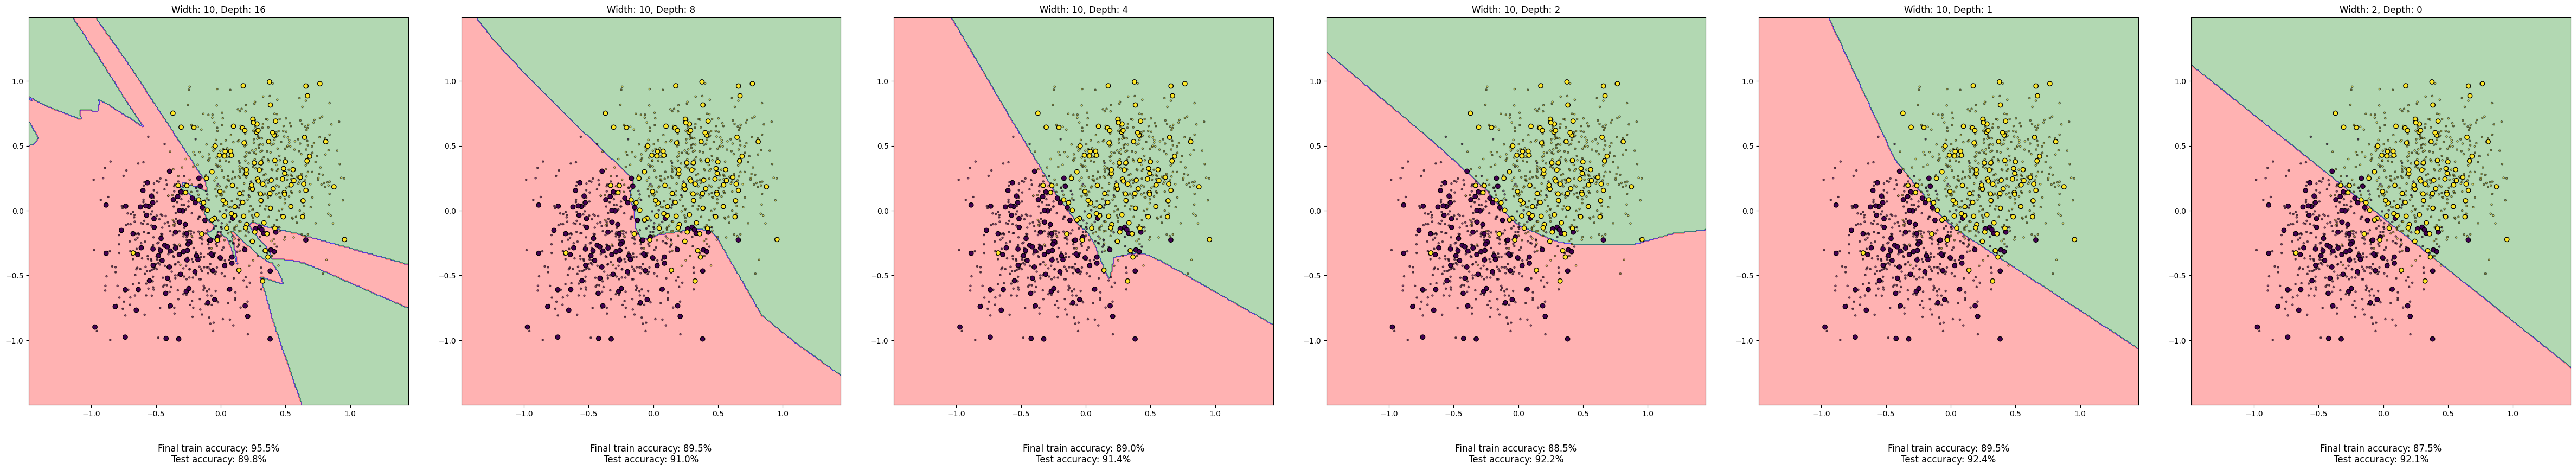

In [22]:
title_generatorNN = lambda params: f"Width: {params['widths'][1]}, Depth: {len(params['widths']) - 2}"
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generatorNN, trained_models=trained_models)

In [23]:
params = {
    'widths': list(map(lambda x: (2,)+(10*x,)*2+(2,), [1,2,4,8]))[::-1],
    'activation': ["ReLU"],
    'optimizer': GDOptimizer(learning_rate=0.5)
}

trained_models = trainNN(params, train_df=train_df, test_df=test_df, num_epochs=7000, num_batches = 1, random_seed=1)

Fitting 5 models with 5 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done



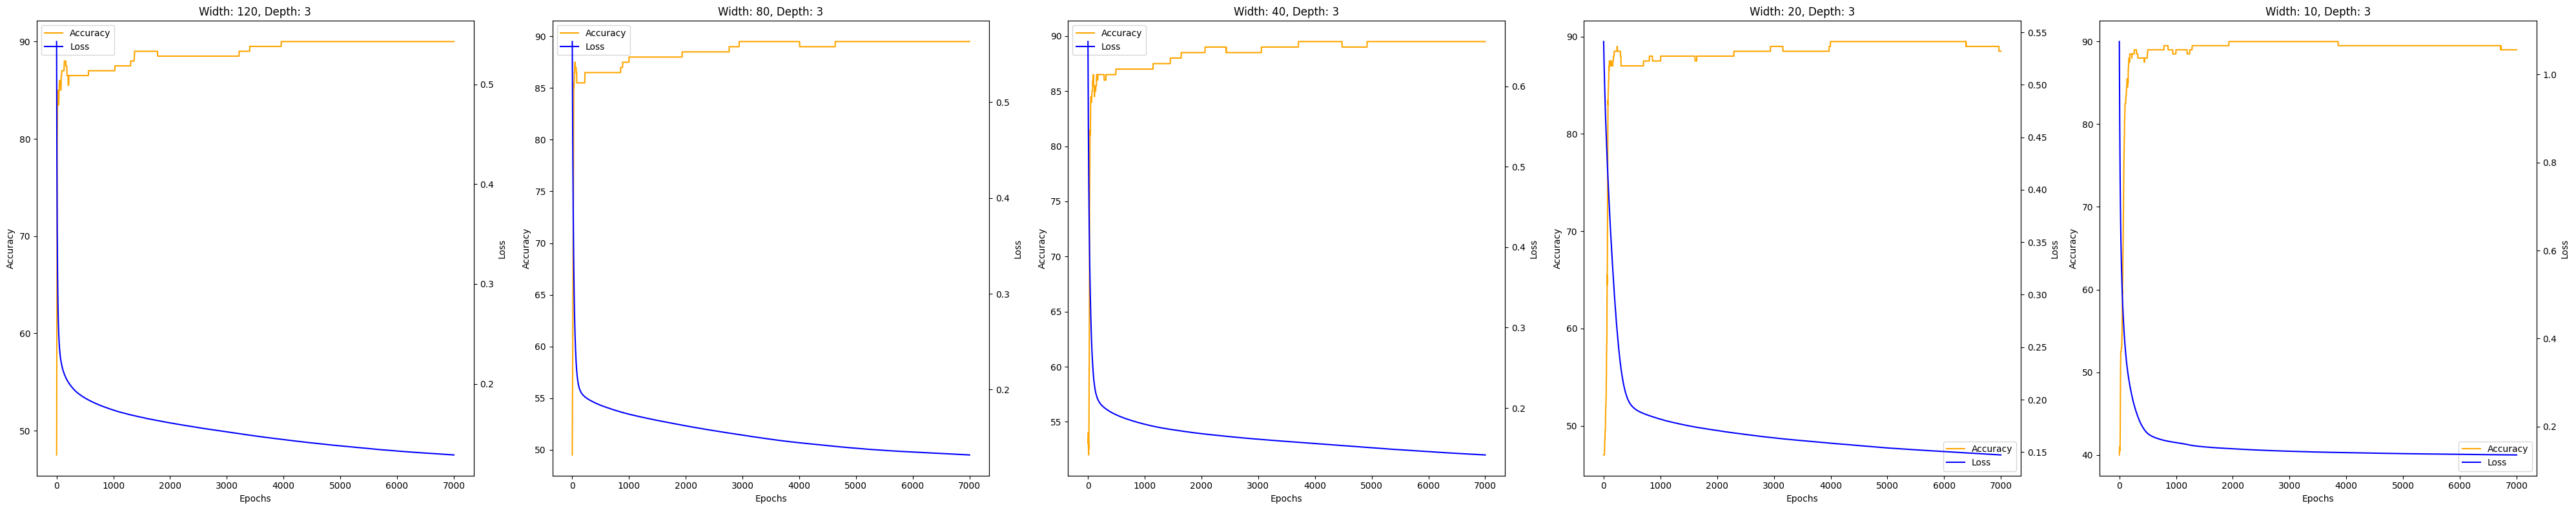

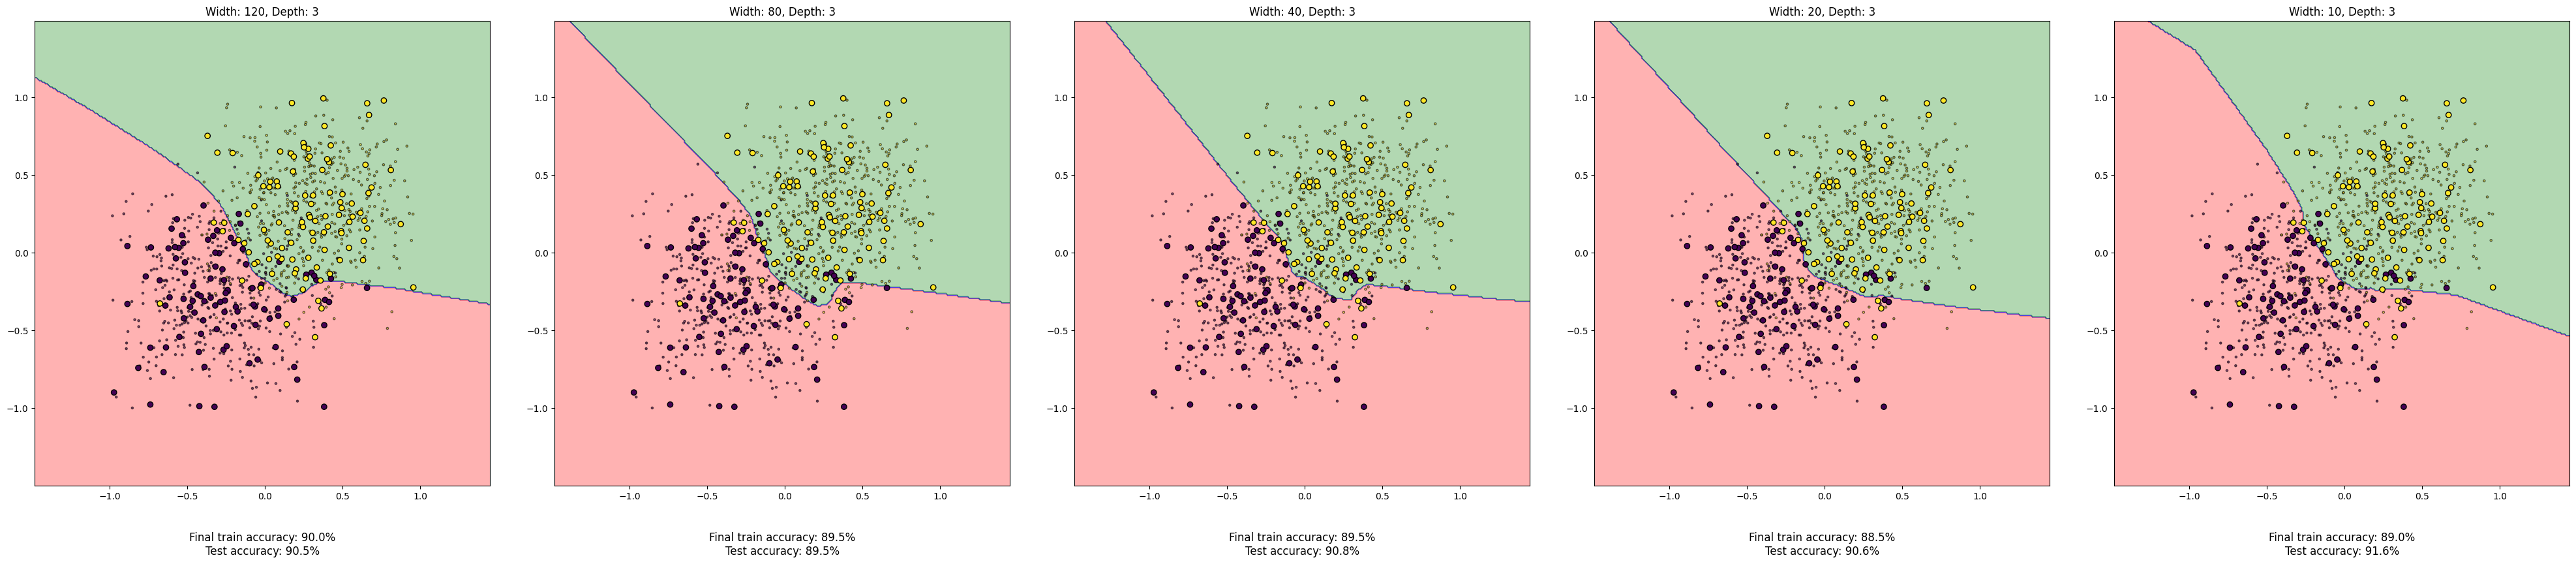

In [24]:
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generatorNN, trained_models=trained_models)

## Kernel SVM

In [25]:
def trainKernelSVM(hyperparameters, test_df, train_df, random_seed):    
    tunable_model = TunableKernelSVM(hyperparameters=hyperparameters)
    
    encode_label = lambda ls: ls.astype("category").cat.codes.to_numpy() * 2 - 1
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model(data[['x', 'y']].to_numpy()), 
            encode_label(data['label']),
            one_hot_encoded_labels=False
        )
        
    configKernelSVM = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=None,
        encode_label=encode_label,
        measure_accuracy=measure_accuracy,
        random_seed=1
    )

    return train_tunable_model(configKernelSVM)

In [26]:
params = {
    'kernel': ['rbf'],
    'sigma': [0.01,0.03,0.1,0.4,1],
    'degree': range(1),
    'intercept': range(3),
}
    
train_split = 0.2
df, train_df, test_df = train_test_split(
    sep_blobs.sample(num_samples=2000),
    training_data_fraction=train_split,
    return_numpy=False
)

trained_models = trainKernelSVM(params, test_df=test_df, train_df=train_df, random_seed=5)

Fitting 5 models with 5 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done



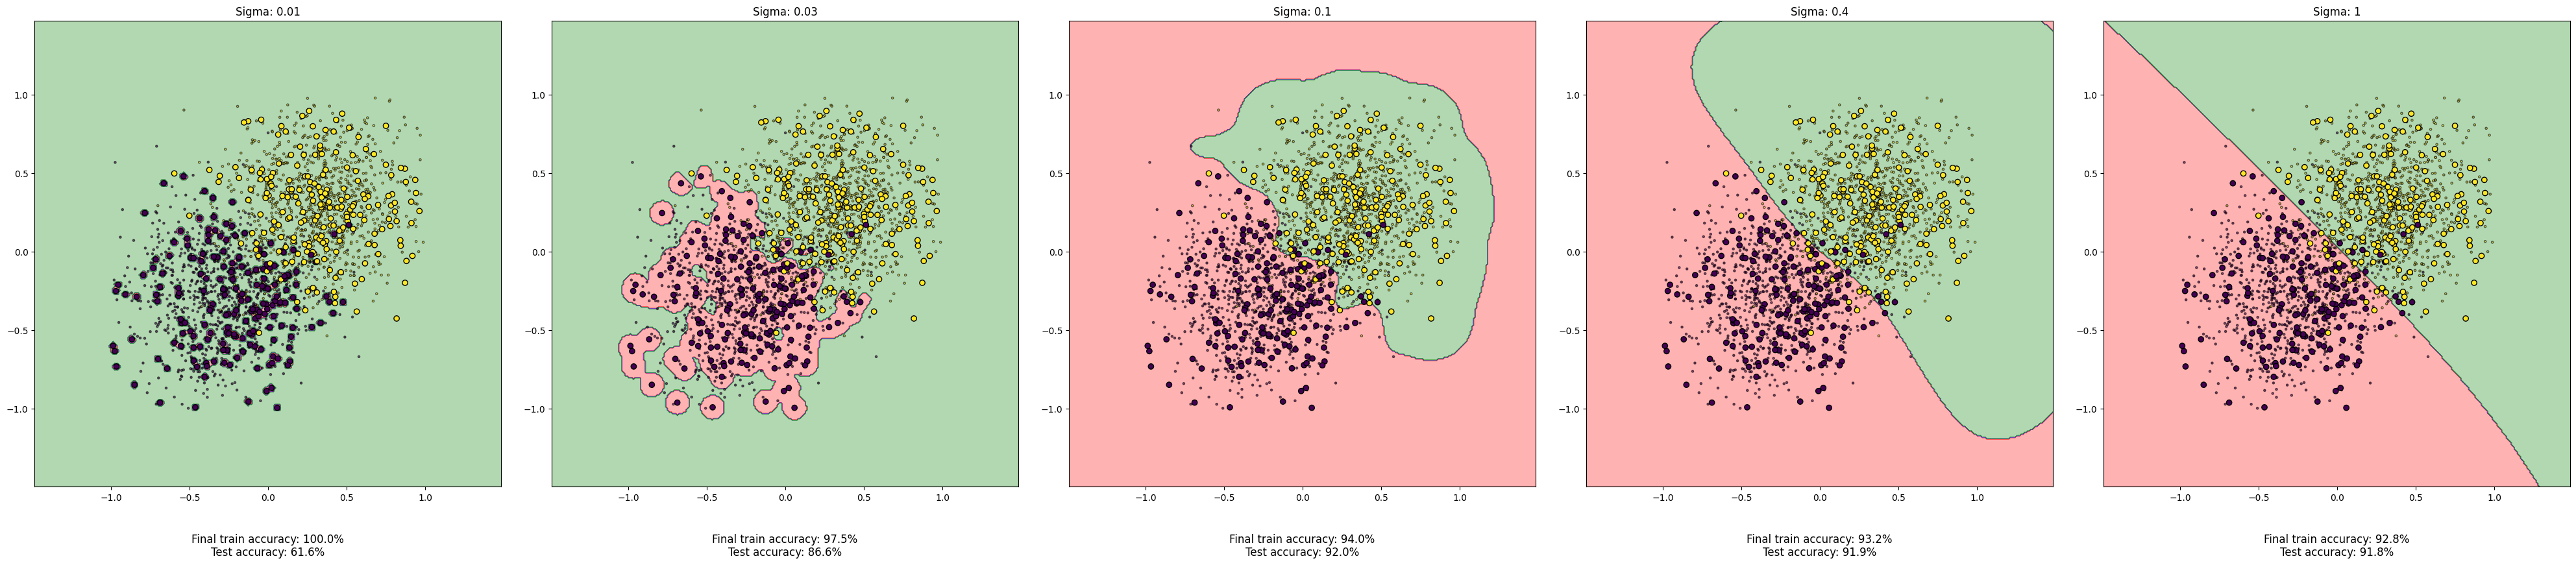

In [27]:
title_generatorKernelSVM = lambda params: f"Sigma: {params['sigma']}"
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generatorKernelSVM, trained_models=trained_models)

## Decision Trees

In [28]:
def trainForest(hyperparameters, test_df, train_df, random_seed):    
    tunable_model = TunableRandomForest(hyperparameters=hyperparameters)
    
    encode_label = lambda ls: ls.to_numpy()
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model.decision_function(data[['x', 'y']].to_numpy()),
            encode_label(data['label']),
            one_hot_encoded_labels=False
        )
        
    configTrees = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=None,
        encode_label=encode_label,
        measure_accuracy=measure_accuracy,
        random_seed=1
    )

    return train_tunable_model(configTrees)

In [29]:
params = {
    'n_estimators': [20],
    'max_depth': [1,2,4,8,16,32,64],
    'min_samples_split': 2,
    'max_features': None
}

train_split = 0.1
df, train_df, test_df = train_test_split(
    sep_blobs.sample(num_samples=5000),
    training_data_fraction=train_split,
    return_numpy=False
)

trained_models = trainForest(params, test_df=test_df, train_df=train_df, random_seed=5)

Fitting 7 models with 7 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done



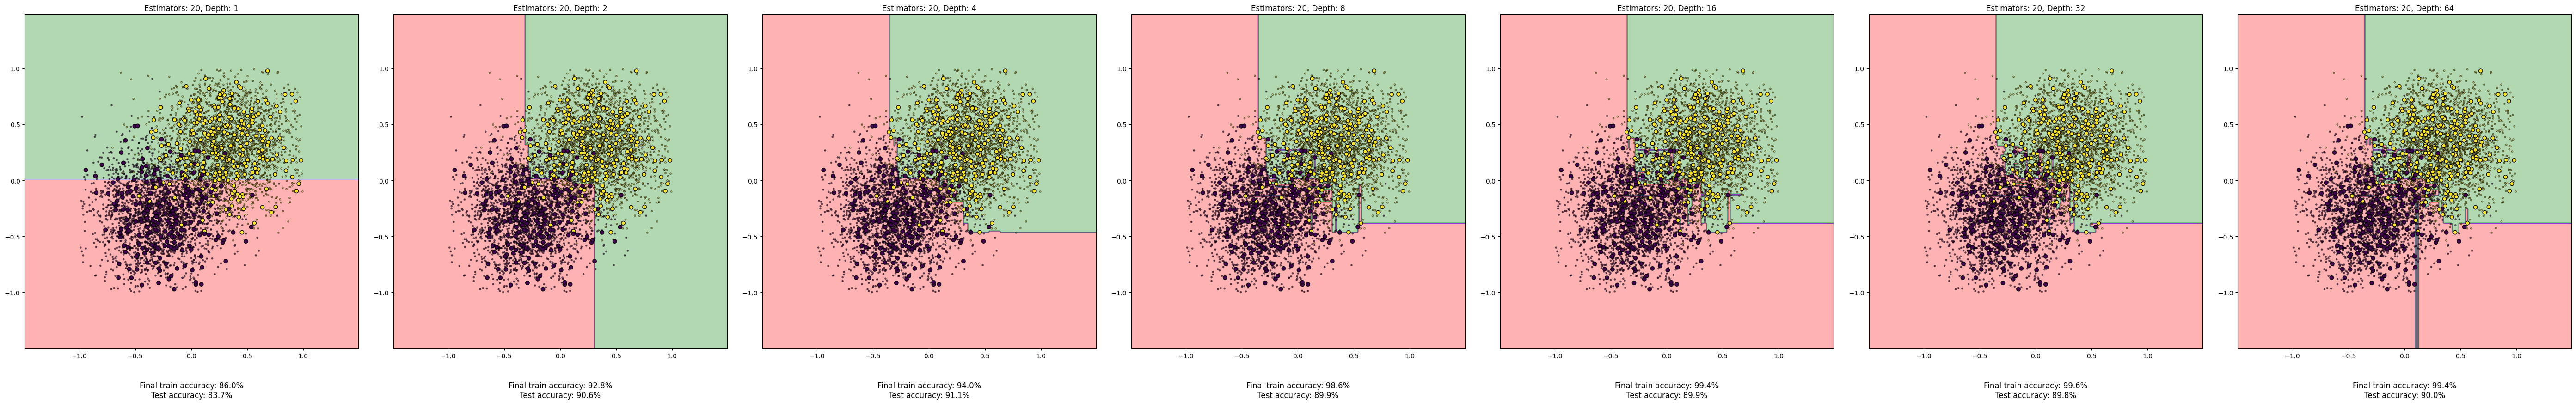

In [30]:
title_generator_forest = lambda params: f"Estimators: {params['n_estimators']}, Depth: {params['max_depth']}"
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generator_forest, trained_models=trained_models)

In [31]:
params = {
    'n_estimators': [1, 5, 20, 50, 100],
    'max_depth': [20],
    'min_samples_split': 2,
    'max_features': None
}

train_split = 0.1
df, train_df, test_df = train_test_split(
    sep_blobs.sample(num_samples=5000),
    training_data_fraction=train_split,
    return_numpy=False
)

trained_models = trainForest(params, test_df=test_df, train_df=train_df, random_seed=5)

Fitting 5 models with 5 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done



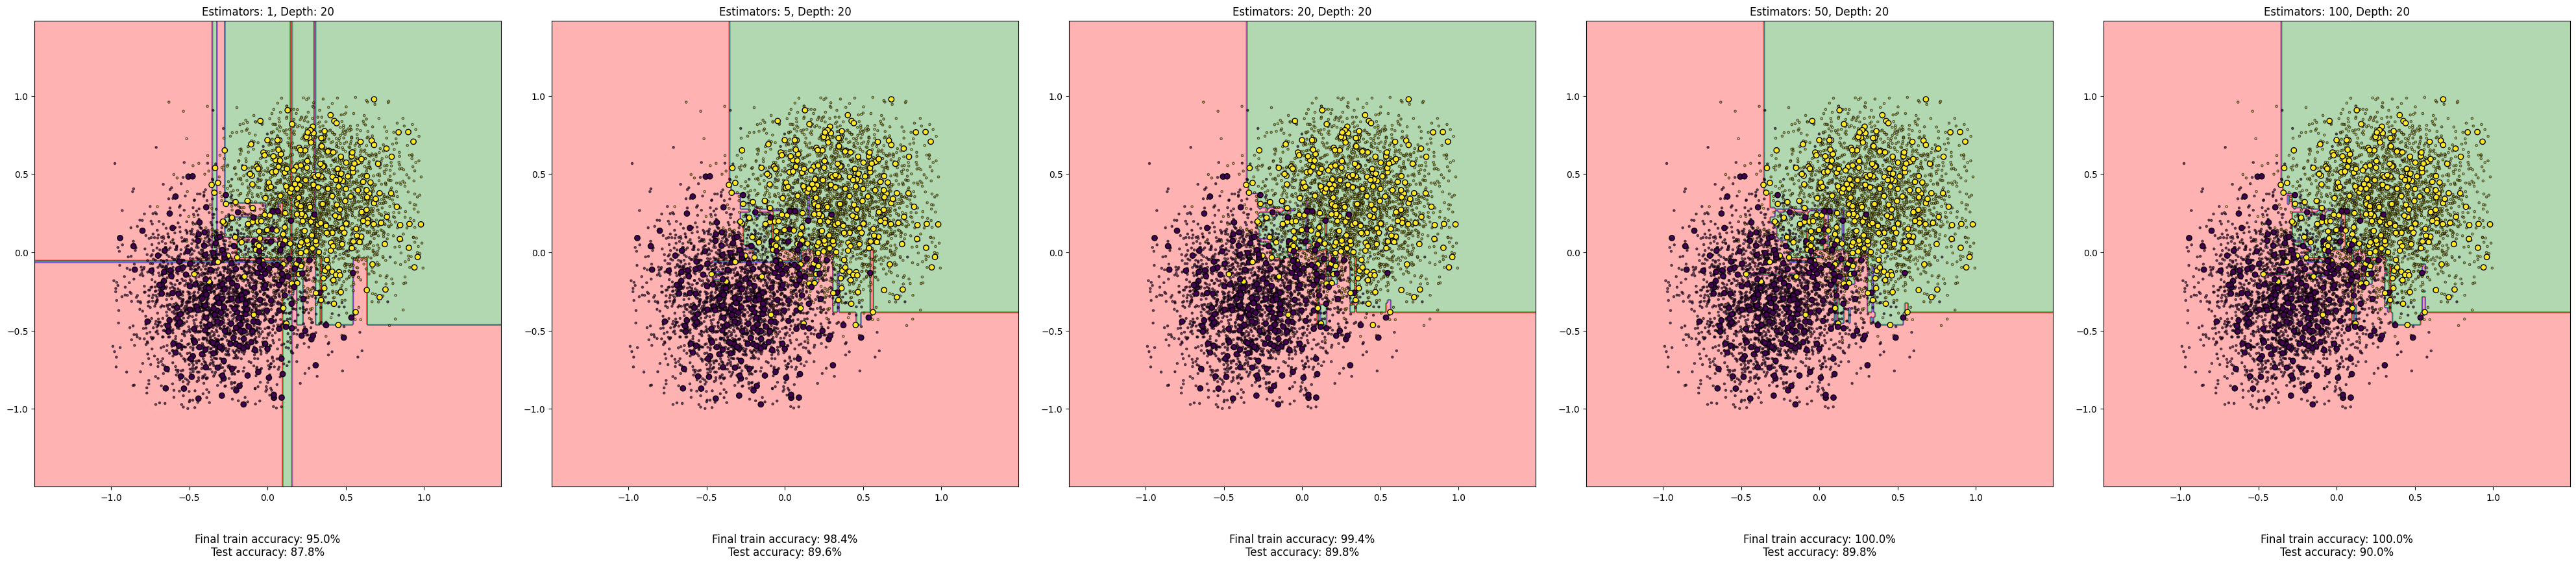

In [32]:
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generator_forest, trained_models=trained_models)

## Final Analysis

In [33]:
class BiasVarianceTradeoff:
    def __init__(self, train_df, test_df, min_cpx, max_cpx, steps_cpx):
        self.train_df = train_df
        self.test_df = test_df
        self.min_cpx = min_cpx
        self.max_cpx = max_cpx
        self.steps_cpx = steps_cpx
    
    def trainNN_with_cpx(self):
        print(f"Training NN")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["NN"])[::-1]
        params = {
            #'widths': list(map(lambda x: (2,)+(20,)*int(2**x-1)+(2,), complexity_range)),
            'widths': list(map(lambda x: (2,int(2**x),int(2**x),2), complexity_range)),
            'activation': ["ReLU"],
            'optimizer': GDOptimizer(learning_rate=0.3)
        }
    
        return (complexity_range,
                trainNN(params, 
                        train_df=self.train_df,
                        test_df=self.test_df,
                        num_epochs=12000,
                        num_batches=1,
                        random_seed=5,
                        show_metrics_history=False))
    
    def trainKernelSVM_with_cpx(self):
        print(f"Training SVM")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["SVM"])[::-1]
        params = {
            'kernel': ['rbf'],
            'sigma': list(map(lambda x: (0.2)**x, complexity_range)),
            'degree': range(1),
            'intercept': range(3),
        }
        
        return complexity_range, trainKernelSVM(params, test_df=self.test_df, train_df=self.train_df, random_seed=5)
    
    def trainForest_with_cpx(self):
        print(f"Training Forest")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["Forest"])[::-1]
        params = {
            'n_estimators': list(map(lambda x: int(4**x), complexity_range)),
            #'max_depth': list(map(lambda x: int(4**x), complexity_range)),
            'max_depth': [20],
            'min_samples_split': 2,
            'max_features': None
        }
        
        return complexity_range, trainForest(params, test_df=self.test_df, train_df=self.train_df, random_seed=5)

    
    def plot_model_accuracy(self, res, ax, model_name):
        complexity_range, trained_models = res
        trained_models.sort(key=lambda x: x["i"])
        #show_tunable_model(train_df=train_df, test_df=test_df, title_generator=title_generatorNN,trained_models=trained_models)
        test_plot = ax.plot(complexity_range,
                           list(map(lambda x: x["acc_test"], trained_models)),
                           label=f"{model_name} Test Acc.")
        color = test_plot[0].get_color()
        ax.plot(complexity_range,
                list(map(lambda x: x["acc_train"], trained_models)),
                linestyle='--',                
                color=color,
                label=f"{model_name} Train Acc.")

    def plot(self):
        fig, ax = plt.subplots()
    
        self.plot_model_accuracy(self.trainNN_with_cpx(), ax=ax, model_name="NN")
        self.plot_model_accuracy(self.trainKernelSVM_with_cpx(), ax=ax, model_name="SVM")
        self.plot_model_accuracy(self.trainForest_with_cpx(), ax=ax, model_name="Forest")
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0,100)
        ax.set_xlabel('Complexity')
        
        plt.title('Bias-variance tradeoff.')
        plt.legend()
        plt.grid()

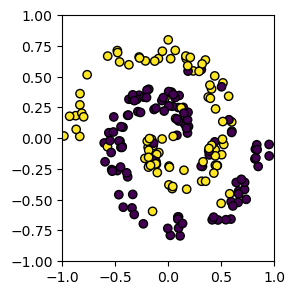

Training NN
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training SVM
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training Forest
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done



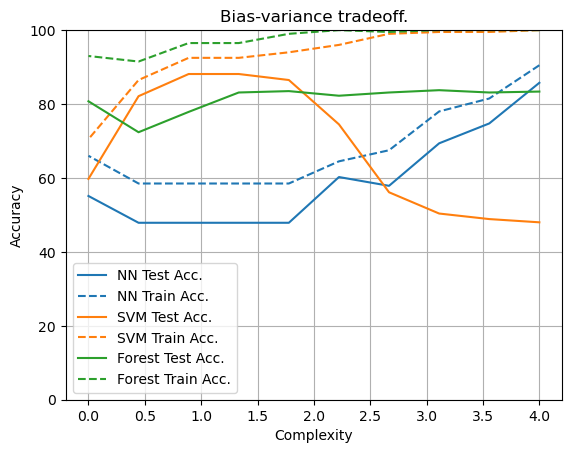

In [34]:
np.random.seed(1)
gen = sp.Spirals(sp.SpiralConf(2, 0.2, 0.1, 0.9, 1))
gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
plot_gen(gen, size=3)

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

BiasVarianceTradeoff(train_df=train_df, test_df=test_df, min_cpx=0, max_cpx=4, steps_cpx={"NN": 10, "SVM": 10, "Forest": 10}).plot()

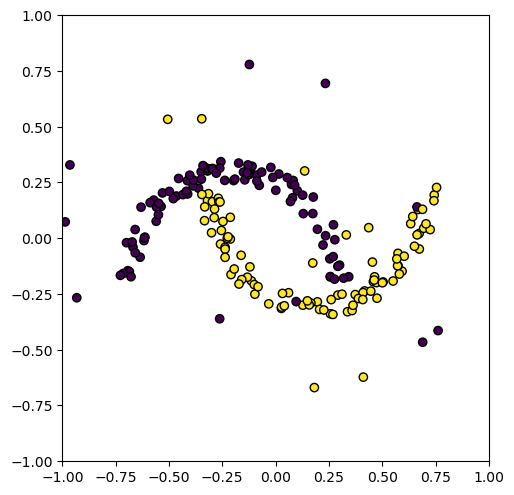

Training NN
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training SVM
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training Forest
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done



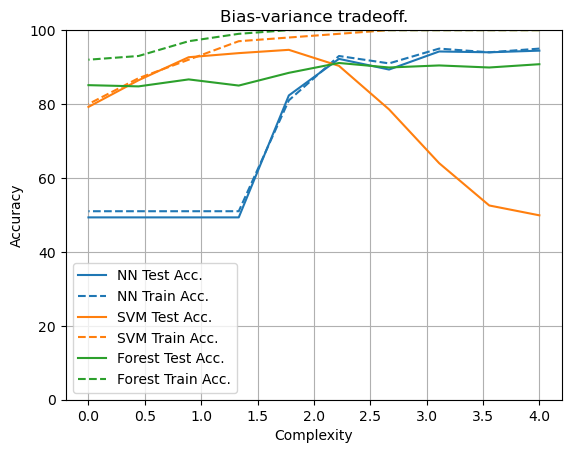

In [35]:
#np.random.seed(1)
#gen = sp.Spirals(sp.SpiralConf(2, 0.25, 0.1, 0.9, 1))
#gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
np.random.seed(1)
#gen = sb.RandomSeparatedBlobs()
# gen = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2), width=0.1, angle_range=(0,5.5)),
#                      hm.HalfMoonConf(centre=(0.2,0.2), width=0.1,angle_range=(3.14,3.14+5.5))])

gen = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2), width=0.1, angle_range=(0,3.14)),
                     hm.HalfMoonConf(centre=(0.2,0.2), width=0.1,angle_range=(3.14,6.28))])
#gen = cc.ConcentricBands([cc.CBandConf(0.7, 0.2),cc.CBandConf(0.3,0.2)])
#gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
gen.add_postprocessor(pp.LabelNoise(noise_freq=0.1, noise_level=0.5))

plot_gen(gen, size=5)

train_split = 0.1
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

BiasVarianceTradeoff(train_df=train_df, test_df=test_df, min_cpx=0, max_cpx=4, steps_cpx={"NN": 10, "SVM": 10, "Forest": 10}).plot()